In [7]:
# Install instructions for replicating the environment for GPAW

# 1. Python headers: To ensure compatibility with the Python version in use, install the Python development headers.
#    On Ubuntu/Debian: `sudo apt-get install python3-dev` or the appropriate package for your Python version.

# 2. LibXC: GPAW requires the LibXC library for exchange-correlation functional computations.
#    Install it via: `sudo apt-get install libxc-dev`

# 3. BLAS/LAPACK: These libraries are essential for numerical linear algebra operations required by GPAW.
#    On Ubuntu/Debian: `sudo apt-get install libblas-dev liblapack-dev`

# 4. GPAW Installation: Once dependencies are in place, install GPAW using pip:
#    `pip install gpaw`

# Make sure that all these dependencies are installed to successfully compile and use GPAW in your projects.

In [95]:
%pip install --upgrade pip
%pip install ase gpaw matplotlib nibabel numpy pandas vtk contourpy
%pip install --upgrade scipy
%pip install rdkit nibabel matplotlib tqdm
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 81.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
import time
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import read, write
from gpaw import GPAW, PW, Mixer, Davidson
import nibabel as nib
from ase.visualize import view
from rdkit import Chem, RDConfig
from ase import Atoms
import subprocess
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
from skimage.feature import peak_local_max

In [11]:
# Directory Paths
SDF_DIR = 'data/sdf'
CIF_DIR = 'data/cif'
NII_DIR = 'data/nii'
TXT_FILES = 'data/txt'  # Folder for text files (GPAW calculation logs)
DENSITY_FILES = 'data/density'  # Folder for density .cube files

# Ensure output directories exist
os.makedirs(NII_DIR, exist_ok=True)
os.makedirs(CIF_DIR, exist_ok=True)
os.makedirs(TXT_FILES, exist_ok=True)
os.makedirs(DENSITY_FILES, exist_ok=True)


In [3]:
# # $ gpaw test
# # ...
# # Could not find any atomic PAW-data or pseudopotentials!

# # You need to set the GPAW_SETUP_PATH environment variable to point to
# # the directories where PAW dataset and basis files are stored.  See
# # https://wiki.fysik.dtu.dk/gpaw/install.html#install-paw-datasets
# # for details.

# on getting this type of error, you can run following commands to fix it:
# $ gpaw install-data --register ~/PAWDATA
# $ export GPAW_SETUP_PATH=~/PAWDATA
# $ source ~/.bashrc

# then restart the kernel (if using ipynb) and run the code again

# Refer to this: https://jensj.gitlab.io/gpaw-2021-talk/slides/slide-09.html

In [12]:
def sdf_to_cif(sdf_filepath):
    mol = read(sdf_filepath)
    mol.center(vacuum=2.5)
    filename = sdf_filepath.split('/')[-1].split('.')[0]
    cif_filepath = os.path.join(CIF_DIR, filename + '.cif')
    write(cif_filepath, mol)
    return mol  # Step 1: Read molecular data from .sdf file

molecules = []
mol_filenames = []
for filename in os.listdir(SDF_DIR):
    if filename.endswith(".sdf"):
        file_path = os.path.join(SDF_DIR, filename)
        mol_filenames.append(filename[:-4])  # Store filename (without extension) for saving later
        mol = sdf_to_cif(file_path)
        molecules.append(mol)

Processing H2...


/tmp/ipykernel_1203479/2629833025.py:21: FutureWarning: Please use atoms.calc = calc
  molecule.set_calculator(calc)


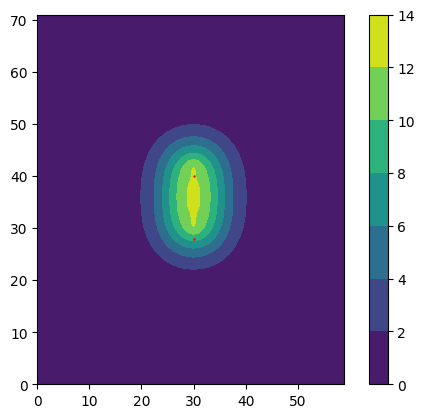

Sum of processed image for H2: 1.649613605436695e-16
Processing times (seconds): [0.3352000389998011]
Calculated energies (eV): {'H2': np.float64(-5.824202071095094)}


In [13]:
cutoffs = [150]  # Example list of cutoff values
times = []
energies = {}  # To store the calculated energies per molecule
calcs = []
densities = []  # To store the calculated densities

for j, molecule in enumerate(molecules):
    print(f"Processing {mol_filenames[j]}...")
    
    # Loop through the cutoff values (for each molecule; you can choose one or loop over all)
    # Here, we use the last cutoff in the list (or you can adjust as needed)
    for cutoff in cutoffs:
        start_time = time.process_time()

        # GPAW calculator setup
        calc = GPAW(xc='LDA',               # Exchange-correlation functional
                    kpts=(1, 1, 1),           # k-points for sampling
                    mode=PW(cutoff),          # Plane wave mode with cutoff energy
                    txt=os.path.join(TXT_FILES, mol_filenames[j] + '.txt')
                   )
        molecule.set_calculator(calc)
        
        # Calculate potential energy
        energy = molecule.get_potential_energy()
        energies[mol_filenames[j]] = energy
        times.append(time.process_time() - start_time)
        
        # Calculate electron density
        density = calc.get_all_electron_density(gridrefinement=4)
        densities.append(density)
        
        # Save the density as a .cube file
        density_file = os.path.join(DENSITY_FILES, mol_filenames[j] + '.cube')
        write(density_file, molecule, data=density)
        
        # ---------------- Change Start: Processing the .cube file similar to the provided code ----------------
        # Open the newly written cube file and skip header lines
        with open(density_file, 'r') as f:
            for _ in range(6):  # Skip the first 6 header lines
                f.readline()
            
            # Read the rest of the file to extract data rows with exactly 5 numbers
            data = np.zeros((0, 5))
            go = True
            while go:
                s = f.readline()
                sNump = np.fromstring(s, sep=' ')
                if sNump.shape[0] == 5:
                    data = np.concatenate((data, [sNump]))
                else:
                    go = False

        # Process extracted data to obtain coordinate positions (likely corresponding to nuclei)
        max_coords = data[:, 2:]  # CHANGE: Extract columns 3-5 from data array
        max_coords[:, 1] *= 6.45  # CHANGE: Scale second coordinate by 6.45
        max_coords[:, 0] *= 6.05  # CHANGE: Scale first coordinate by 6.05
        max_coords[:, 2] = density.shape[2] / 2  # CHANGE: Set the third coordinate to half the density's z-dimension
        max_coords = np.int64(max_coords)
        
        # Project density along the z-axis to obtain a 2D map for visualization (optional)
        nred = np.sum(density, axis=2)
        plt.contourf(nred)
        plt.colorbar()
        ax = plt.gca()
        fig = plt.gcf()
        # Overlay the positions (swapping x and y for plotting consistency)
        plt.scatter(max_coords[:, 1], max_coords[:, 0], c='r', marker='o', s=(72./fig.dpi)**2)
        ax.set_aspect(1)
        plt.show()
        
        # Prepare density for image processing: remove negatives
        density2 = np.copy(density)
        density2[density2 < 0] = 0
        
        # Sum the density at each nuclear position
        nbAtom = max_coords.shape[0]  # CHANGE: Number of atoms/points detected from cube data
        s_total = 0
        for i in range(nbAtom):
            s_total += density2[tuple(max_coords[i, :])]
        
        # Compute a scaled image from density data
        image = -density2 / ((np.sum(density2) - s_total) / nbAtom)
        
        # Mark the nuclear positions in the image (set to 1)
        for i in range(nbAtom):
            image[tuple(max_coords[i, :])] = 1  # CHANGE: Override nucleus position value with 1
        print(f"Sum of processed image for {mol_filenames[j]}:", np.sum(image))
        # ---------------- Change End --------------------------------------------

        # Convert the (processed) density to .nii format.
        # CHANGE: You can choose to save the original density or the processed "image".
        # Here, we choose to save the original density as in the provided snippet.
        nii_file = os.path.join(NII_DIR, mol_filenames[j] + '.nii')
        nifti_img = nib.Nifti1Image(density, affine=None)
        nib.save(nifti_img, nii_file)
        # If you'd rather save the processed image, use:
        # nifti_img = nib.Nifti1Image(image, affine=None)
        # nib.save(nifti_img, nii_file)

# After processing all molecules, output timing and energy information
print("Processing times (seconds):", times)
print("Calculated energies (eV):", energies)


/tmp/ipykernel_1203479/3257993124.py:14: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  sNump = np.fromstring(s, sep=' ')


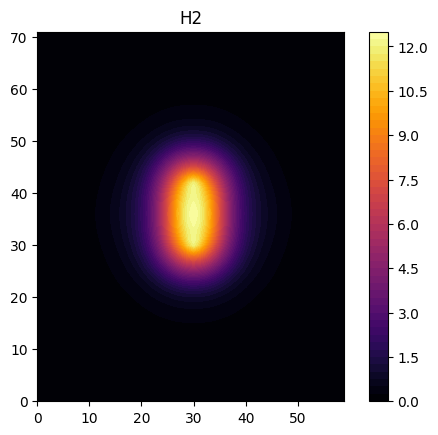

In [15]:
DENSITY_FILES = "data/density"  # update this to your actual directory

data_list = []
molecule_names = []

# Loop over files and load data; also store the filename (or molecule name)
for filename in os.listdir(DENSITY_FILES):
    pFile = os.path.join(DENSITY_FILES, filename)
    with open(pFile, 'r') as file:
        data = np.zeros((0, 5))
        go = True
        while go:
            s = file.readline()
            sNump = np.fromstring(s, sep=' ')
            if sNump.shape[0] == 5:
                data = np.concatenate((data, [sNump]))
            else:
                go = False
    data_list.append(data)
    molecule_names.append(filename.split('.')[0])  # store the filename (or use another label if desired)

# Assuming that 'densities' is defined somewhere and is in one-to-one correspondence with data_list.
# Loop through data_list (and molecule_names) to process each density and atom information
for i in range(len(data_list)):
    # Process atom positions from your data - you might need to adjust depending on your data structure.
    # Here, max is assumed to contain the atom positions in columns 2 onward.
    max_data = data_list[i][:, 2:]
    # Scale factors for more prominent atom positions and larger spread
    max_data[:, 1] *= 8.0  # Increased scaling factor for X
    max_data[:, 0] *= 7.5  # Increased scaling factor for Y
    
    # Setting the third coordinate, assuming densities[i] is 3D and you want to center the atoms.
    # Adjust this if densities is defined differently.
    max_data[:, 2] = densities[i].shape[2] / 2  
    max_data = np.int64(max_data)

    # Sum over the third axis to create a 2D grid, this gives your density contour plot
    nred = np.sum(densities[i], axis=2)

    # (Optional) sort densities if needed
    sortedDensity = np.argsort(densities[i].flatten())

    # Create a contour plot with more levels for finer distinction
    plt.contourf(nred, levels=60, cmap='inferno')
    plt.colorbar()

    ax = plt.gca()
    fig = plt.gcf()

    # Scatter plot for atoms (using the scaled positions)
    atom_size = (72. / fig.dpi)**2 * 2  # Increase marker size by a factor of 2
    plt.scatter(max_data[:, 1], max_data[:, 0], c='r', marker='o', s=atom_size)
    
    # Add the molecule name as a label/title on the plot
    plt.title(molecule_names[i])
    
    # Optionally, you can also annotate individual atom positions:
    # for j, (x, y, z) in enumerate(max_data):
    #     plt.text(x, y, str(j), color='w', fontsize=8)
    
    # Set the aspect ratio to keep the plot proportional
    ax.set_aspect(1)
    
    # Display the plot
    plt.show()


In [12]:
# # Loop through all the NII files
# for filename in os.listdir(NII_DIR):
#     if filename.endswith(".nii"):
#         nii_filepath = os.path.join(NII_DIR, filename)
#         nii_data = nib.load(nii_filepath).get_fdata()
        
#         # Get the number of slices along the z-axis (assuming it's the third axis)
#         num_slices = nii_data.shape[2]
        
#         # Set the maximum number of slices per row (5 to 7 slices)
#         slices_per_row = 7  # Maximum slices per row
#         rows = (num_slices // slices_per_row) + (num_slices % slices_per_row > 0)  # Calculate the number of rows

#         # Create a figure with subplots
#         fig, axes = plt.subplots(rows, slices_per_row, figsize=(20, 4 * rows))  # Adjust the figsize as needed
        
#         # Flatten axes array if it's multi-dimensional
#         axes = axes.flatten()

#         # Loop through each slice and plot it
#         for slice_index in range(num_slices):
#             ax = axes[slice_index]
#             ax.imshow(nii_data[:, :, slice_index], cmap='jet')  # Display the slice
            
#             # Format the title with the slice index and its x, y, z positions
#             z_index = slice_index  # The slice index along the z-axis
#             x_index = nii_data.shape[0] // 2  # Example: middle of the x-axis
#             y_index = nii_data.shape[1] // 2  # Example: middle of the y-axis
#             ax.set_title(f"Slice {z_index} [{x_index}:{y_index}:{z_index}]")  # Title with slice index and coordinates
            
#             ax.axis('off')  # Hide the axes

#         # Hide any unused subplots (if num_slices is less than the total subplot grid)
#         for i in range(num_slices, len(axes)):
#             axes[i].axis('off')

#         # Adjust layout to avoid overlapping titles and axes
#         plt.tight_layout()
#         plt.show()


In [16]:
def process_single_file(file_name, input_data, output_keypoint_images):
    """
    Processes a single .nii file by constructing the command and running it.
    """
    input_file_path = os.path.join(input_data, file_name)
    output_file_name = file_name.replace('.nii', '.key')
    output_file_path = os.path.join(output_keypoint_images, output_file_name)
    command = ['./../featExtract.ubu', input_file_path, output_file_path]
    
    try:
        result = subprocess.run(command, check=True, capture_output=True, text=True)
        print(f"Successfully processed {file_name}")
    except subprocess.CalledProcessError as e:
        print(f"Error processing {file_name}: {e.stderr}")

def process_nii_files(input_data, output_keypoint_images):
    """
    Processes all .nii files in the input folder in parallel and generates corresponding .key files in the output folder.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_keypoint_images):
        os.makedirs(output_keypoint_images)
    
    # Get the list of all .img files in the input folder
    img_files = [file for file in os.listdir(input_data) if file.endswith('.nii')]
    
    # Use a ProcessPoolExecutor to process files in parallel
    with ProcessPoolExecutor() as executor:
        # Submit all files for processing
        futures = {
            executor.submit(process_single_file, file_name, input_data, output_keypoint_images): file_name
            for file_name in img_files
        }
        # Use tqdm to display progress as futures complete
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files", unit="file"):
            try:
                future.result()  # Raises exception if one occurred in process_single_file
            except Exception as e:
                print(f"Error occurred: {e}")

# Example usage:
input_data = "data/nii"
output_keypoint_images = "data/key_website_pre-compiled/"  # Change if you want to save in a different folder
process_nii_files(input_data, output_keypoint_images)

Processing files:   0%|          | 0/10 [00:00<?, ?file/s]

Successfully processed H2.nii


Processing files:  10%|█         | 1/10 [00:00<00:02,  3.28file/s]

Successfully processed L-valine.nii


Processing files:  20%|██        | 2/10 [00:01<00:07,  1.08file/s]

Successfully processed D-Fructose.nii


Processing files:  30%|███       | 3/10 [00:01<00:04,  1.69file/s]

Successfully processed D-alanine-3D.nii


Processing files:  40%|████      | 4/10 [00:02<00:02,  2.41file/s]

Successfully processed L-leucine.nii
Successfully processed alpha-Methylhistidine.nii


Processing files:  60%|██████    | 6/10 [00:02<00:01,  3.67file/s]

Successfully processed D-Glucose.nii


Processing files:  70%|███████   | 7/10 [00:02<00:00,  4.30file/s]

Successfully processed D-phenylalanine.nii


Processing files:  80%|████████  | 8/10 [00:02<00:00,  3.16file/s]

Successfully processed L-tryptophan.nii


Processing files:  90%|█████████ | 9/10 [00:03<00:00,  3.01file/s]

Successfully processed Sucrose.nii


Processing files: 100%|██████████| 10/10 [00:03<00:00,  2.78file/s]


In [17]:
import key2vtk

key2vtk.run_processing(
    base_path="~/Desktop/Experiments/molecules/data",
    key_subdir="key_website_pre-compiled",
    vtk_subdir="vtk_website_pre-compiled"
)

2025-06-05 14:03:59,284 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/D-Fructose.key:              X           Y          Z     Scale       o11       o12       o13  \
0    49.343227  102.918930  17.153448  3.893006 -0.198427 -0.234647 -0.951613   
1    49.343227  102.918930  17.153448  3.893006 -0.196844 -0.588492  0.784175   
2    49.343227  102.918930  17.153448  3.893006 -0.196844 -0.588492  0.784175   
3    49.343227  102.918930  17.153448  3.893006 -0.196844 -0.588492  0.784175   
4    29.865900   16.513605  25.522575  3.621213 -0.190114  0.981199 -0.033245   
..         ...         ...        ...       ...       ...       ...       ...   
135  71.042854   45.124813  56.848450  9.977474 -0.368781  0.380897 -0.847890   
136  71.042854   45.124813  56.848450  9.977474 -0.368781  0.380897 -0.847890   
137  71.042854   45.124813  56.848450  9.977474 -0.804226 -0.059476 -0.591340   
138  71.042854   45.124813  56.

Number of positive features: 10
Number of negative features: 12
Number of positive features: 10
Number of negative features: 12
Number of positive features: 0
Number of negative features: 0


2025-06-05 14:04:00,465 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/L-tryptophan.key:              X           Y          Z      Scale       o11       o12  \
0    61.703754  108.928284  13.271890   3.716451 -0.113022  0.930889   
1    61.703754  108.928284  13.271890   3.716451  0.175673 -0.591942   
2    61.703754  108.928284  13.271890   3.716451  0.175673 -0.591942   
3    61.703754  108.928284  13.271890   3.716451  0.175673 -0.591942   
4    80.406425  111.201920  18.573307   3.655777 -0.313011 -0.494372   
..         ...         ...        ...        ...       ...       ...   
340  82.716133   73.571648  56.091633  12.659277 -0.273258  0.869317   
341  82.716133   73.571648  56.091633  12.659277  0.159220 -0.575988   
342  82.716133   73.571648  56.091633  12.659277 -0.820639  0.422039   
343  82.716133   73.571648  56.091633  12.659277 -0.820639  0.422039   
344  82.716133   73.571648  56.091633  12.65927

Negative volume: 4095.346
Number of positive features: 39
Number of negative features: 14
Number of positive features: 39
Number of negative features: 14


2025-06-05 14:04:03,370 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/L-valine.key:              X          Y          Z      Scale       o11       o12       o13  \
0    91.438385  12.050385  45.843594   3.907421 -0.345535  0.415797 -0.841260   
1    91.438385  12.050385  45.843594   3.907421 -0.359544  0.832055  0.422390   
2    91.438385  12.050385  45.843594   3.907421 -0.359544  0.832055  0.422390   
3    91.438385  12.050385  45.843594   3.907421 -0.359544  0.832055  0.422390   
4    91.438385  12.050385  45.843594   3.907421 -0.359544  0.832055  0.422390   
..         ...        ...        ...        ...       ...       ...       ...   
187  75.567902  46.524975  54.992142   9.710940 -0.636369 -0.646096  0.421421   
188  75.567902  46.524975  54.992142   9.710940 -0.636369 -0.646096  0.421421   
189  67.443764  41.878376  56.288376  12.337897 -0.659221 -0.059181 -0.749617   
190  67.443764  41.878376  56.288

Number of positive features: 0
Number of negative features: 0
Negative volume: 5008.023
Number of positive features: 18
Number of negative features: 11
Number of positive features: 18
Number of negative features: 11


2025-06-05 14:04:04,911 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/H2.key:             X          Y          Z     Scale       o11       o12       o13  \
0   36.500088  30.500000  18.409630  6.362988  0.000004 -0.000000 -1.000000   
1   36.500088  30.500000  18.409630  6.362988 -0.000001 -0.574574  0.818452   
2   36.500088  30.500000  18.409630  6.362988 -0.000001  0.574574  0.818452   
3   36.500000  25.650145  19.514818  6.436213  0.000000  0.000000 -1.000000   
4   36.500000  25.650145  19.514818  6.436213  0.000000  0.583690  0.811976   
..        ...        ...        ...       ...       ...       ...       ...   
57  36.480259  30.514254  30.514252  8.403145 -0.003047 -0.825233  0.564784   
58  36.480259  30.514254  30.514252  8.403145 -0.003047  0.564784 -0.825233   
59  36.480259  30.514254  30.514252  8.403145 -0.003047  0.564784 -0.825233   
60  36.480259  30.514254  30.514252  8.403145 -0.003578 -0.

Number of positive features: 0
Number of negative features: 0
Negative volume: 4029.866
Number of positive features: 17
Number of negative features: 1
Number of positive features: 17
Number of negative features: 1


2025-06-05 14:04:05,441 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/D-phenylalanine.key:              X          Y          Z      Scale       o11       o12       o13  \
0    64.636330  48.943336   9.889797   3.621086 -0.587026  0.771600 -0.245019   
1    64.636330  48.943336   9.889797   3.621086 -0.590007  0.006341  0.807373   
2    64.636330  48.943336   9.889797   3.621086 -0.590007  0.006341  0.807373   
3    64.636330  48.943336   9.889797   3.621086 -0.590007  0.006341  0.807373   
4    64.636330  48.943336   9.889797   3.621086 -0.590007  0.006341  0.807373   
..         ...        ...        ...        ...       ...       ...       ...   
324  50.012722  84.651711  47.632729  10.500297  0.585714 -0.211848  0.782342   
325  50.012722  84.651711  47.632729  10.500297  0.585714 -0.211848  0.782342   
326  50.012722  84.651711  47.632729  10.500297  0.585714 -0.211848  0.782342   
327  50.012722  84.651711 

Number of positive features: 0
Number of negative features: 0
Negative volume: 2485.502
Number of positive features: 39
Number of negative features: 13
Number of positive features: 39
Number of negative features: 13


2025-06-05 14:04:08,124 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/Sucrose.key:               X          Y          Z      Scale       o11       o12  \
0     78.626038  73.775551  15.537476   3.900130 -0.179354  0.485613   
1     78.626038  73.775551  15.537476   3.900130  0.630655 -0.420480   
2    129.775299  32.673321  16.569944   3.769879 -0.086040 -0.097330   
3    129.775299  32.673321  16.569944   3.769879 -0.067449  0.812050   
4    129.775299  32.673321  16.569944   3.769879 -0.067449  0.812050   
..          ...        ...        ...        ...       ...       ...   
379  108.201599  68.583740  77.692535  12.513444 -0.421421  0.299864   
380  108.201599  68.583740  77.692535  12.513444  0.094539 -0.789721   
381  108.201599  68.583740  77.692535  12.513444  0.094539 -0.789721   
382  108.201599  68.583740  77.692535  12.513444  0.094539 -0.789721   
383  108.201599  68.583740  77.692535  12.513444  0.

Number of positive features: 0
Number of negative features: 0
Negative volume: 4330.073
Number of positive features: 37
Number of negative features: 23
Number of positive features: 37
Number of negative features: 23


2025-06-05 14:04:11,264 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/alpha-Methylhistidine.key:               X          Y          Z      Scale       o11       o12  \
0     27.559084  73.099098  14.296266   3.670968 -0.689871  0.434589   
1     27.559084  73.099098  14.296266   3.670968  0.614738 -0.021832   
2     27.559084  73.099098  14.296266   3.670968  0.614738 -0.021832   
3    118.579552  74.543304  19.213428   3.785306 -0.590579  0.786199   
4    118.579552  74.543304  19.213428   3.785306 -0.595625  0.222229   
..          ...        ...        ...        ...       ...       ...   
208   60.724266  72.330032  61.121384  10.293714  0.815062  0.579286   
209   60.724266  72.330032  61.121384  10.293714  0.386514 -0.808914   
210   60.724266  72.330032  61.121384  10.293714  0.386514 -0.808914   
211   60.724266  72.330032  61.121384  10.293714  0.386514 -0.808914   
212   60.724266  72.330032  61.121384 

Number of positive features: 0
Number of negative features: 0
Negative volume: 8156.393
Number of positive features: 19
Number of negative features: 14
Number of positive features: 19
Number of negative features: 14


2025-06-05 14:04:13,003 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/D-alanine-3D.key:              X          Y          Z      Scale       o11       o12       o13  \
0    29.628601  77.855949  12.502451   3.666475  0.168006 -0.869465 -0.464548   
1    29.628601  77.855949  12.502451   3.666475  0.433089 -0.254122  0.864787   
2    29.628601  77.855949  12.502451   3.666475  0.433089 -0.254122  0.864787   
3    29.628601  77.855949  12.502451   3.666475  0.433089 -0.254122  0.864787   
4    29.628601  77.855949  12.502451   3.666475  0.433089 -0.254122  0.864787   
..         ...        ...        ...        ...       ...       ...       ...   
179  54.638962  40.887871  57.333790  10.208336  0.102429 -0.880497 -0.462853   
180  54.638962  40.887871  57.333790  10.208336 -0.051366  0.806514 -0.588980   
181  54.638962  40.887871  57.333790  10.208336 -0.051366  0.806514 -0.588980   
182  54.638962  40.887871  57

Number of positive features: 0
Number of negative features: 0
Negative volume: 4522.065
Number of positive features: 21
Number of negative features: 8
Number of positive features: 21
Number of negative features: 8


2025-06-05 14:04:14,493 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/L-leucine.key:              X          Y          Z      Scale       o11       o12       o13  \
0    16.706783  62.710262  27.471754   3.857914 -0.631156  0.694115  0.346190   
1    16.706783  62.710262  27.471754   3.857914  0.787855 -0.446811  0.423844   
2    16.706783  62.710262  27.471754   3.857914  0.787855 -0.446811  0.423844   
3    91.803040  18.035946  28.161619   3.825717 -0.708002 -0.024841 -0.705774   
4    91.803040  18.035946  28.161619   3.825717 -0.797583  0.603195 -0.004137   
..         ...        ...        ...        ...       ...       ...       ...   
240  72.594734  72.654297  64.926796  10.318284  0.816651  0.020191 -0.576778   
241  51.338306  47.022415  68.575279  10.117741 -0.549917  0.691170 -0.468909   
242  51.338306  47.022415  68.575279  10.117741 -0.566956 -0.205285 -0.797759   
243  51.338306  47.022415  68.57

Number of positive features: 0
Number of negative features: 0
Negative volume: 2841.050
Number of positive features: 23
Number of negative features: 13
Number of positive features: 23
Number of negative features: 13


2025-06-05 14:04:16,485 - WARNING - Duplicate positions found in /home/aryanshukla/Desktop/Experiments/molecules/data/key_website_pre-compiled/D-Glucose.key:               X          Y          Z      Scale       o11       o12  \
0    118.449219  94.031723  13.141690   3.717649 -0.247738  0.613343   
1    118.449219  94.031723  13.141690   3.717649 -0.574888 -0.577709   
2    118.449219  94.031723  13.141690   3.717649 -0.574888 -0.577709   
3     74.714180  18.775473  14.691120   3.755670 -0.236591  0.469227   
4     74.714180  18.775473  14.691120   3.755670 -0.197505  0.576260   
..          ...        ...        ...        ...       ...       ...   
199  101.423546  66.835419  68.808167  10.031789 -0.828658 -0.152917   
200  101.423546  66.835419  68.808167  10.031789 -0.828658 -0.152917   
201  101.423546  66.835419  68.808167  10.031789 -0.828658 -0.152917   
202  101.423546  66.835419  68.808167  10.031789 -0.828658 -0.152917   
203  101.423546  66.835419  68.808167  10.031789 -

Number of positive features: 0
Number of negative features: 0
Negative volume: 5186.790
Number of positive features: 19
Number of negative features: 14
Number of positive features: 19
Number of negative features: 14


2025-06-05 14:04:18,120 - INFO - Volume summary written to /home/aryanshukla/Desktop/Experiments/molecules/data/volume_summary.csv


Number of positive features: 0
Number of negative features: 0
Negative volume: 4793.113


## Matching XYZ Coordinates of Features and Atoms

In [18]:
def read_key_file(key_file_path):
    """
    Reads the key file and returns the data as a DataFrame.
    Expects the file to have 13 columns (after skipping 6 header rows) with the following order:
    X, Y, Z, Scale, o11, o12, o13, o21, o22, o23, o31, o32, o33, e1, e2, e3, InfoFlag
    """
    try:
        data = pd.read_csv(key_file_path, skiprows=6, header=None, sep=r'\s+', usecols=range(17))
        data.columns = ['X', 'Y', 'Z', 'Scale', 
                        'o11', 'o12', 'o13', 'o21', 'o22', 'o23', 'o31', 'o32', 'o33', 'e1', 'e2', 'e3', 'InfoFlag']
        return data
    except Exception as e:
        raise

In [18]:
data = read_key_file('data/key_website_pre-compiled/D-Fructose.key')

In [19]:
coordinates = data.loc[data['InfoFlag'] == 16][['X', 'Y', 'Z']]

In [20]:
coordinates.reset_index(drop=True, inplace=True)

In [21]:
coordinates

,X,Y,Z
0,30.565393,70.174919,37.145771
1,32.689213,46.007298,41.060585
2,69.683548,29.971365,43.389767
3,97.109344,73.549118,45.983353
4,34.629665,73.381226,60.830357
5,86.581978,57.272354,69.136169
6,85.796074,57.187950,31.121950
7,58.264553,49.576973,36.120262
8,91.209221,44.627365,43.084026
9,55.777493,90.225334,56.590439


Number of peaks detected: 27


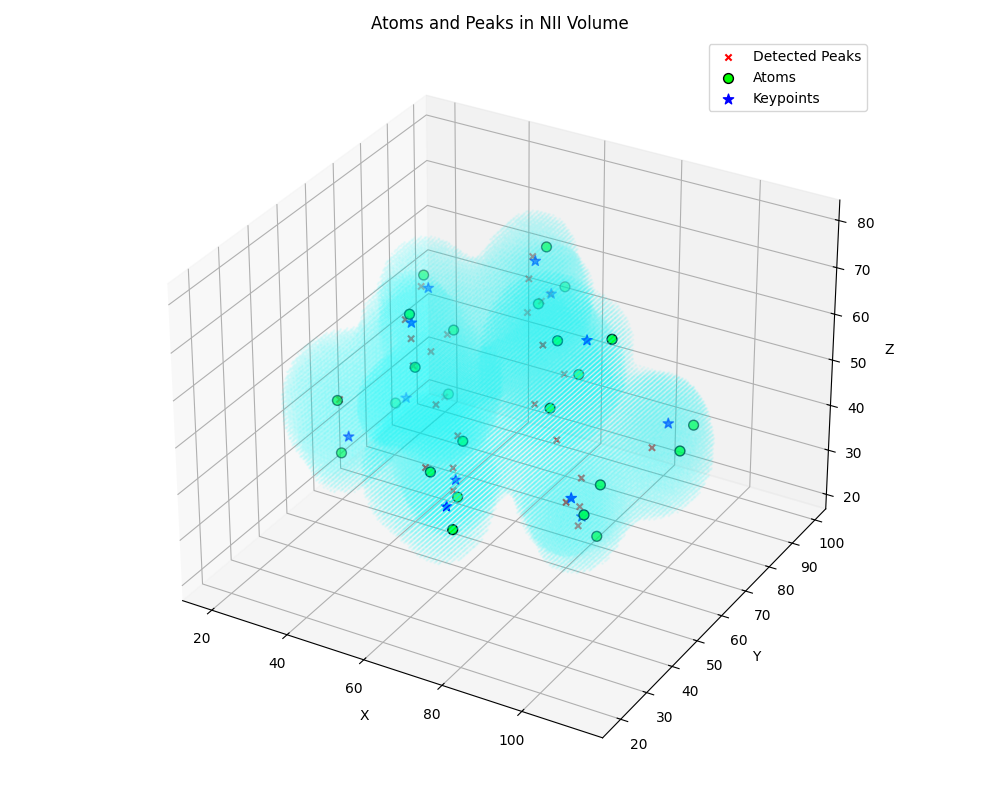

In [22]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import peak_local_max
from rdkit import Chem
from rdkit.Chem import AllChem

# File paths
nii_file = 'data/nii/D-Fructose.nii'
sdf_file = 'data/sdf/D-Fructose.sdf'

# Load NIfTI density
img = nib.load(nii_file)
data = img.get_fdata()
shape = np.array(data.shape)

# Detect peaks in voxel space
coordinates_vox = peak_local_max(data, min_distance=3, threshold_abs=0.5)
print(f"Number of peaks detected: {len(coordinates_vox)}")


# Load atoms from SDF (including H)
mol = Chem.MolFromMolFile(sdf_file, removeHs=False)
conf = mol.GetConformer()
atom_coords = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])

# --- Coordinate system alignment ---

# Step 1: Center atom coordinates around origin
atom_coords_centered = atom_coords - atom_coords.mean(axis=0)

# Step 2: Scale atom coordinates to match .nii volume size
max_range = np.max(np.linalg.norm(atom_coords_centered, axis=1))  # max radius from center
scale_factor = min(shape) / (2 * max_range * 1.2)  # slight margin
atom_coords_scaled = atom_coords_centered * scale_factor

# Step 3: Shift to center of volume
atom_coords_vox = atom_coords_scaled + shape / 2

# --- Plotting ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Cyan cloud for density (thresholded)
threshold = 0.1
x, y, z = np.where(data > threshold)
ax.scatter(x, y, z, c='cyan', alpha=0.05, s=1)

# Red crosses for detected peaks
ax.scatter(coordinates_vox[:, 0], coordinates_vox[:, 1], coordinates_vox[:, 2],
           c='red', marker='x', label='Detected Peaks')

# Green atoms (scaled and centered)
ax.scatter(atom_coords_vox[:, 0], atom_coords_vox[:, 1], atom_coords_vox[:, 2],
           c='lime', edgecolors='black', s=50, label='Atoms')

ax.scatter(
    coordinates['X'], coordinates['Y'], coordinates['Z'],
    color='blue', marker='*', s=60, label='Keypoints'
)

ax.set_title("Atoms and Peaks in NII Volume")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.savefig('/home/aryanshukla/Desktop/Experiments/Results/PeaksAtomsAlignment/PeaksAtoms.png', dpi=300)
plt.show()


In [57]:
%pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


X: [[0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]]
Y: [[0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6]
 [7 7 7 7 7 7 7 7]]
Z: [[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  1.62980699e-34 -2.30489515e-34  1.62980699e-34
  -1.41134123e-49 -1.62980699e-34  2.30489515e-34 -1.62980699e-34]
 [ 0.00000000e+00 -2.30489515e-34  3.25961398e-34 -2.30489515e-34
   1.99593792e-49  2.30489515e-34 -3.25961398e-34  2.30489515e-34]
 [-0.00000000e+00  1.62980699e-34 -2.30489515e-34  1.62980699e-34
  -1.41134123e-49 -1.62980699e-34  2.30489515e-34 -1.62980699e-34]
 [ 0.00000000e+00 -1.41134123e-49  1.99593792e-49 -1.41134123e-49
   1.22215949e-64  1.41134123e-49 -1.99593792e-49  1.41134123e-49]
 [ 0.00000000e+00 -1

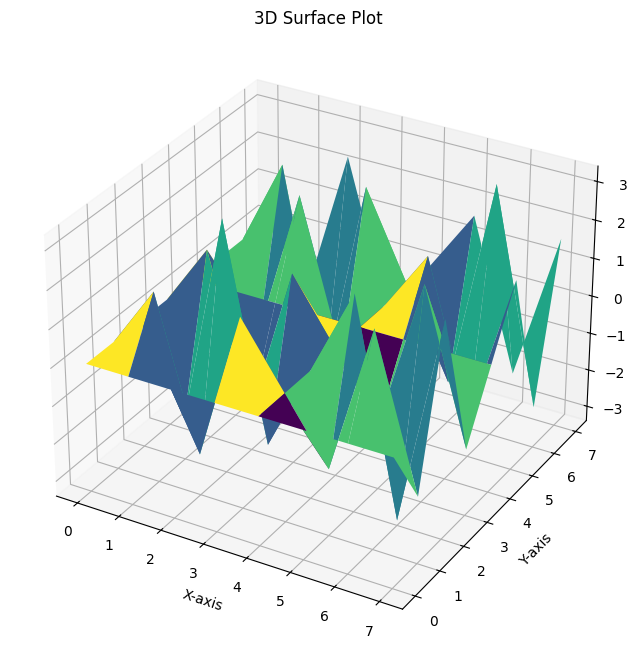

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100
n = 10
m = 10

length = 8
width = 8
initialScale = 1.0
scales = []
divPerOctave = 2

# Compute scales; note that we use a different variable (j) in the inner loop for clarity
for i in range(N):
    scalesPerOctave = [initialScale * (2 ** (j / divPerOctave)) for j in range(N)]
    scales.append(scalesPerOctave)

alpha = 0.5

def scaleSpace(sigma):
    # Create coordinate arrays
    x = np.arange(length)
    y = np.arange(width)
    # Create a 2D grid for the surface
    X, Y = np.meshgrid(x, y)
    # Compute Z on the grid
    # Note: Parentheses clarify the denominator for the exponential term.
    Z = (np.sin(n * np.pi * X / length) *
         np.sin(m * np.pi * Y / width) *
         np.exp(- (m * n * np.pi**2 * alpha * sigma) / (length * width)))
    return X, Y, Z

# Generate the data with a chosen sigma (e.g., sigma = 10)
X, Y, Z = scaleSpace(10)
print("X:", X)
print("Y:", Y)
print("Z:", Z)
# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add titles and labels
ax.set_title("3D Surface Plot")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()


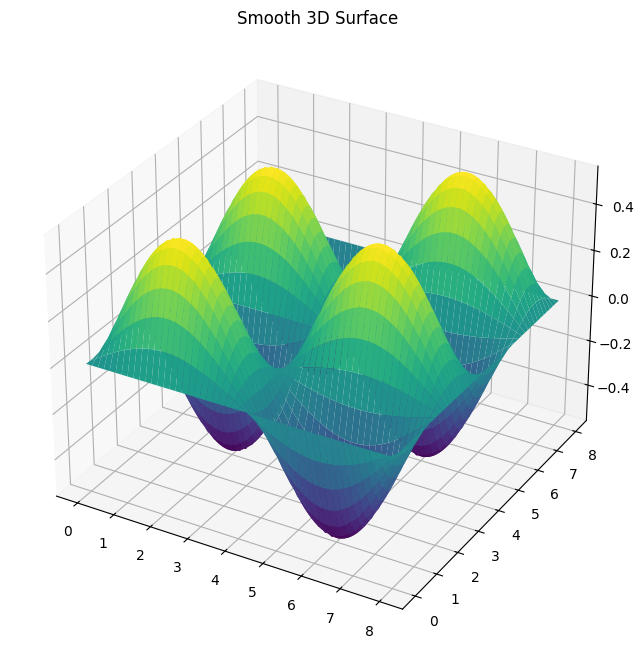

In [ ]:
length = 8
width = 8
n, m = 2, 4
alpha = 0.5
sigma = 1

# Dense grid instead of integer-only
x = np.linspace(0, length, 500)
y = np.linspace(0, width, 500)
X, Y = np.meshgrid(x, y)

Z = (np.sin(n * np.pi * X / length) *
     np.sin(m * np.pi * Y / width) *
     np.exp(- (m * n * np.pi**2 * alpha * sigma) / (length * width)))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title("Smooth 3D Surface")
plt.show()

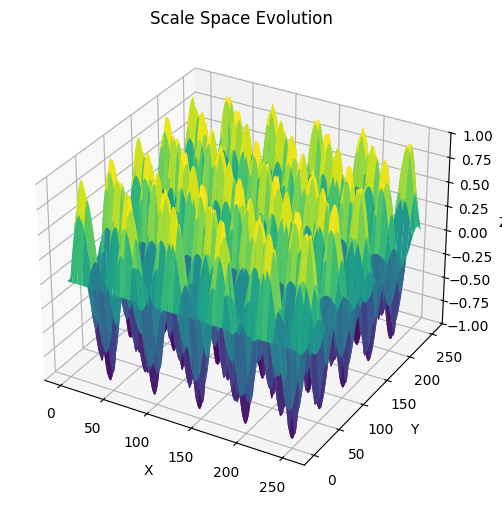

In [9]:
from matplotlib.animation import FuncAnimation

# Parameters
n, m = 10, 10
length, width = 256, 256
alpha = 0.5

# Meshgrid
x = np.arange(length)
y = np.arange(width)
X, Y = np.meshgrid(x, y)

# Scale space function
def scaleSpace(sigma):
    Z = (np.sin(n * np.pi * X / length) *
         np.sin(m * np.pi * Y / width) *
         np.exp(- (m * n * np.pi**2 * alpha * sigma) / (length * width)))
    return Z

# Create figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Initial surface
Z = scaleSpace(1.0)
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_zlim(-1, 1)  # Fixed z-limits
ax.set_title("Scale Space Evolution")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Update function for animation
def update(frame):
    sigma = frame
    ax.clear()
    Z = scaleSpace(sigma)
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title(f"Sigma = {sigma:.2f}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_zlim(-1, 1)

# Animation setup
sigmas = np.linspace(1, 100, 60)  # 60 frames
ani = FuncAnimation(fig, update, frames=sigmas, interval=1)

# To display in notebook (if using Jupyter)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# To save as video or gif:
# ani.save("scale_space.mp4", writer='ffmpeg')  # Needs ffmpeg installed
# ani.save("scale_space.gif", writer='pillow')  # For gif output

plt.show()


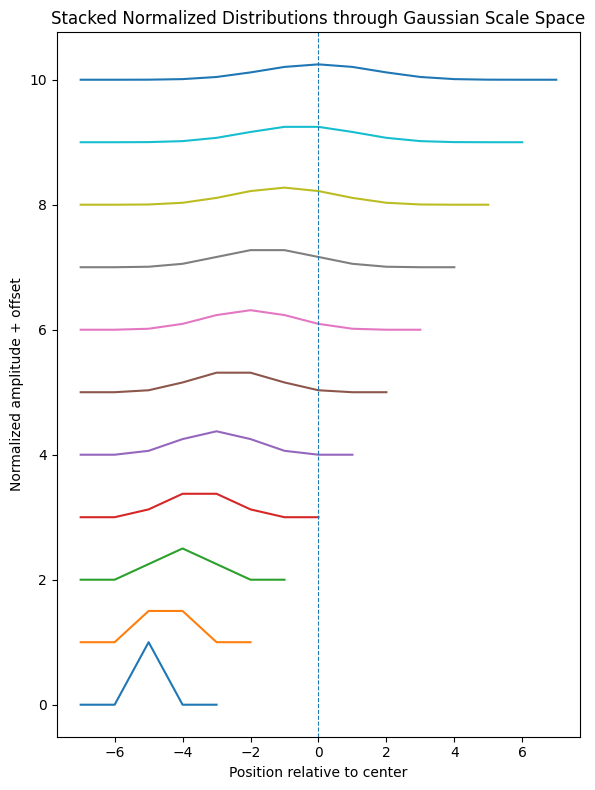

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def convolve_full_1d(signal, kernel, relu=False):
    result = np.convolve(signal, kernel, mode='full')
    if relu:
        result = np.maximum(result, 0)
    return result

def successive_full_convolutions(image, kernel, n, relu=True):
    current = image.copy()
    rows = [current]
    for _ in range(n):
        current = convolve_full_1d(current, kernel, relu)
        rows.append(current)
    return rows

# Parameters
image = np.array([0, 0, 1, 0, 0])
kernel = np.array([1, 1])
n = 10

# Generate pyramid of rows
pyramid = successive_full_convolutions(image, kernel, n)

# Plot stacked normalized curves with vertical offsets
plt.figure(figsize=(6, 8))
center = len(pyramid[-1]) // 2
for i, row in enumerate(pyramid):
    norm_row = row / row.sum()
    x = np.arange(len(row)) - center
    y = norm_row + i  # vertical offset by row index
    plt.plot(x, y)
# Draw vertical center line
plt.axvline(0, linestyle='--', linewidth=0.8)
plt.xlabel('Position relative to center')
plt.ylabel('Normalized amplitude + offset')
plt.title('Stacked Normalized Distributions through Gaussian Scale Space')
plt.tight_layout()
plt.show()
